In [3]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from calibration_metric.vis.calibration_plot import plot_df 
from calibration_metric.metric import ECEMetric

plt.rcParams["font.family"] = "Nimbus Roman"

from calibration_utils import read_nucleus_file, read_gold_file,get_probs_and_accs, read_benchclamp_file, get_probs_and_accs_benchclamp

In [4]:
miso_min_probs, miso_mean_probs, miso_accs = get_probs_and_accs("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/test_all.tgt",
                                "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/test_all.src_tok",
                                "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/test_all.tgt") 


bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221101T105421.jsonl")
bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 

t5_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221102T103315.jsonl")
t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_benchclamp(t5_data)

Mean acc: 0.788335322195704
len accs: 13408


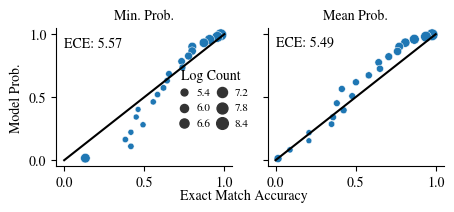

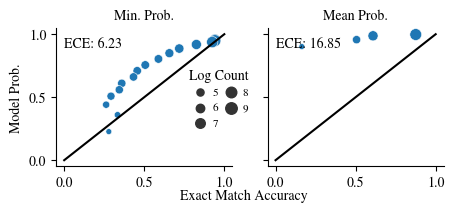

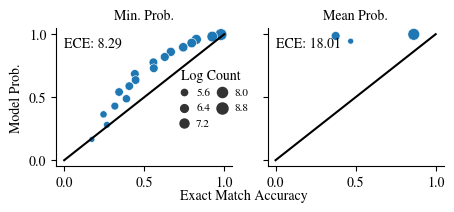

In [9]:
def comparison_plot(min_probs, mean_probs, accs, path, n_bins = 10, binning_strategy='uniform'):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    min_df_to_plot = ece_metric.bins_to_df(min_values, min_bins, min_bin_number)
    min_ece = ece_metric(np.array(min_probs), np.array(accs))
    min_ece *= 100

    if binning_strategy == "uniform":
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.uniform_bin(mean_probs, accs)
    else:
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.adaptive_bin(mean_probs, accs)

    mean_df_to_plot = ece_metric.bins_to_df(mean_values, mean_bins, mean_bin_number)
    mean_ece = ece_metric(np.array(mean_probs), np.array(accs))
    mean_ece *= 100

    fig, ax = plt.subplots(1,2, figsize=(5,1.8), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax[0].set_title("Min. Prob.", fontsize=10)
    ax[1].set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot, ylabel="Model Prob.", xlabel=None, ax = ax[0], show_legend=False, metric_value=min_ece, metric_value_kwargs = metric_kwargs)
    plot = plot_df(mean_df_to_plot, ylabel="Model Prob.", xlabel=None, ax=ax[1], show_legend=False, metric_value=mean_ece, metric_value_kwargs=metric_kwargs) 
    # ax[0].set_xlabel("EM Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})
    fig.text(0.5, -0.05, "Exact Match Accuracy", ha="center", va="center", fontsize=10)

    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    # plt.tight_layout()
    # plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/seq_calibration.pdf", bbox_inches='tight')
    plt.savefig(path, bbox_inches='tight')
    return min_values, min_bins, min_bin_number


miso_values, miso_bins, miso_bin_number = comparison_plot(miso_min_probs, miso_mean_probs, miso_accs, "/home/estengel/papers/did-you-mean-2022/figures/miso_seq_calibration_adaptive.pdf", n_bins=10, binning_strategy='adaptive')
bart_values, bart_bins, bart_bin_number = comparison_plot(bart_min_probs, bart_mean_probs, bart_accs, "/home/estengel/papers/did-you-mean-2022/figures/bart_seq_calibration_adaptive.pdf", n_bins=10, binning_strategy='adaptive')
t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, t5_mean_probs, t5_accs, "/home/estengel/papers/did-you-mean-2022/figures/t5_seq_calibration_adaptive.pdf", n_bins=10, binning_strategy='adaptive')

Mean acc: 0.8728817308968629
len accs: 22601


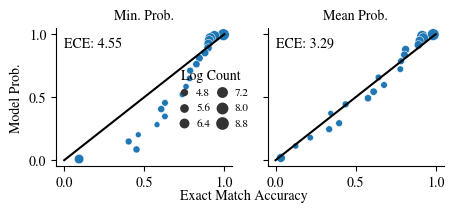

In [10]:
(treedst_min_probs, 
treedst_mean_probs, 
treedst_accs) = get_probs_and_accs(
                "/brtx/603-nvme1//estengel/calflow_calibration/tree_dst/tune_roberta/translate_output_calibrated/test.tgt",
                "/brtx/601-nvme1/estengel/resources/data/tree_dst.agent.data/test.src_tok",
                "/brtx/601-nvme1/estengel/resources/data/tree_dst.agent.data/test.tgt"
                ) 

treedst_miso_bin_number = comparison_plot(treedst_min_probs, treedst_mean_probs, treedst_accs, "/home/estengel/scratch/scratch_adaptive.png", n_bins=10, binning_strategy='adaptive')

In [21]:
import numpy as np
np.random.seed(12)
# stratified sample 
# bin_number has bin assignment 
# values has the mean acc of the bin 
# bins has the bin edges 

examples_by_bin = defaultdict(list)
idxs_by_bin_number = defaultdict(list)
for i, bin_num in enumerate(miso_bin_number):
    idxs_by_bin_number[bin_num].append(i)


for i, (acc, edge_start) in enumerate(zip(miso_values, miso_bins)):
    edge_end = miso_bins[i+1]
    midpoint = (edge_start + edge_end) / 2
    midpoint = f"{midpoint:.2f}"
    examples_by_bin[midpoint] = idxs_by_bin_number[i+1]

gold_src = read_gold_file("/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.src_tok")
gold_tgt = read_gold_file("/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt") 
nucleus = read_nucleus_file("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all.tgt")


# we want 100 total examples, 10 per bin 
n_samples_per_bin = 10 

sampled_source = defaultdict(list)
sampled_target = defaultdict(list)
sampled_nucleus = defaultdict(list)
sampled_idx_dict = defaultdict(list)
for midpoint, idxs in examples_by_bin.items():
    # reduce to idxs that are not fences 
    before_len = len(idxs)
    idxs = [i for i in idxs if "Fence" not in gold_tgt[i] and "Pleasantry" not in gold_tgt[i]]
    after_len = len(idxs)
    assert(before_len > after_len)

    sampled_idxs = np.random.choice(idxs, size=n_samples_per_bin, replace=False)
    for idx in sampled_idxs:
        sampled_source[midpoint].append(gold_src[idx])
        sampled_target[midpoint].append(gold_tgt[idx])
        nucleus_list = nucleus[gold_src[idx]]
        sampled_nucleus[midpoint].append(nucleus_list)
        sampled_idx_dict[midpoint].append(idx)

# write tgt 
out_file = "../hit/data/for_hit_round_2/stratified_data_by_bin.tgt"
tgt_out_file = "../hit/data/for_hit_round_2/gold_data/stratified_data_by_bin.tgt"
idx_out_file = "../hit/data/for_hit_round_2/gold_data/stratified_data_by_bin.idx"
src_out_file = "../hit/data/for_hit_round_2/gold_data/stratified_data_by_bin.src_tok"
bin_out_file = "../hit/data/for_hit_round_2/gold_data/stratified_data_by_bin.bins"
with open(out_file, "w") as f1, \
    open(tgt_out_file, "w") as tgtf, \
    open(src_out_file, "w") as srcf, \
    open(idx_out_file, "w") as idxf, \
    open(bin_out_file, "w") as binf:
    for midpoint, nuc_list in sampled_nucleus.items():
        for nuc_sublist in nuc_list:
            for nuc, min_prob, total_prob in nuc_sublist:
                nuc['midpoint'] = float(midpoint) 
                nuc['min_prob'] = min_prob
                nuc = json.dumps(nuc)
                f1.write(nuc + "\n")
            binf.write(str(midpoint) + "\n")
        tgt_str_list = sampled_target[midpoint]
        for tgt_str in tgt_str_list:
            tgtf.write(tgt_str.strip() + "\n")

        src_str_list = sampled_source[midpoint]
        for src_str in src_str_list:
            srcf.write(src_str.strip() + "\n")
        idx_list = sampled_idx_dict[midpoint]
        for idx in idx_list:
            idxf.write(str(idx) + "\n")

IndexError: list index out of range

In [ ]:

# stratified sample number 2 
# bin_number has bin assignment 
# values has the mean acc of the bin 
# bins has the bin edges 

prev_idx_file = "../hit/data/for_hit_round_2/gold_data/stratified_data_by_bin.idx"
with open(prev_idx_file) as f1:
    prev_idxs = [int(line.strip()) for line in f1]
prev_idx_file = "../hit/data/for_hit_round_3/gold_data/stratified_data_by_bin.idx"
with open(prev_idx_file) as f1:
    prev_idxs += [int(line.strip()) for line in f1]

sampled_source = defaultdict(list)
sampled_target = defaultdict(list)
sampled_nucleus = defaultdict(list)
sampled_idx_dict = defaultdict(list)
for midpoint, idxs in examples_by_bin.items():
    # reduce to idxs that are not fences 
    before_len = len(idxs)
    # restrict to examples that we didn't do before
    idxs = [i for i in idxs if "Fence" not in gold_tgt[i] and "Pleasantry" not in gold_tgt[i] and i not in prev_idxs]
    after_len = len(idxs)
    assert(before_len > after_len)

    sampled_idxs = np.random.choice(idxs, size=n_samples_per_bin, replace=False)
    for idx in sampled_idxs:
        sampled_source[midpoint].append(gold_src[idx])
        sampled_target[midpoint].append(gold_tgt[idx])
        nucleus_list = nucleus[gold_src[idx]]
        sampled_nucleus[midpoint].append(nucleus_list)
        sampled_idx_dict[midpoint].append(idx)

# write tgt 
out_file = "../hit/data/for_hit_round_4/stratified_data_by_bin.tgt"
tgt_out_file = "../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.tgt"
idx_out_file = "../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.idx"
src_out_file = "../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.src_tok"
bin_out_file = "../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.bins"
with open(out_file, "w") as f1, \
    open(tgt_out_file, "w") as tgtf, \
    open(src_out_file, "w") as srcf, \
    open(idx_out_file, "w") as idxf, \
    open(bin_out_file, "w") as binf:
    for midpoint, nuc_list in sampled_nucleus.items():
        for nuc_sublist in nuc_list:
            for nuc, min_prob, total_prob in nuc_sublist:
                nuc['midpoint'] = float(midpoint) 
                nuc['min_prob'] = min_prob
                nuc = json.dumps(nuc)
                f1.write(nuc + "\n")
            binf.write(str(midpoint) + "\n")
        tgt_str_list = sampled_target[midpoint]
        for tgt_str in tgt_str_list:
            tgtf.write(tgt_str.strip() + "\n")

        src_str_list = sampled_source[midpoint]
        for src_str in src_str_list:
            srcf.write(src_str.strip() + "\n")
        idx_list = sampled_idx_dict[midpoint]
        for idx in idx_list:
            idxf.write(str(idx) + "\n")

# Now that we've run the HIT, let's analyze the results

In [ ]:
import sys
sys.path.insert(0, "/home/estengel/incremental-function-learning/")
sys.path.insert(0, "/home/estengel/incremental-function-learning/hit")
sys.path.insert(0, "/home/estengel/incremental-function-learning/hit/scripts")
from hit.results.analyze_csv import run_choose_and_rewrite, read_json, read_csv, clean_lispress
import pdb 
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

turk_file = "../hit/results/round5_probs/Batch_4907707_batch_results.csv"
json_file = "../hit/data/for_hit/from_stratified_round_4/for_hit_list_with_probs/data.json"

turk_data, is_list = read_csv(turk_file)
json_data = read_json(json_file)

class Args:
    checkpoint_dir = "/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data"
    aggregator = "none"
    n_redundant = 1

args = Args()
non_rewritten_data, rewritten_data = run_choose_and_rewrite(turk_data, json_data, args, is_list=is_list)

In [ ]:
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 

non_rewritten_correct_to_plot = []
hit_dict = defaultdict(list)
for nr in non_rewritten_data:
    hit_dict[nr['json_entry']['bin']].append(int(nr['is_correct_most_likely']))

# we can add rewritten to the same plot
for r in rewritten_data:
    hit_dict[r['json_entry']['bin']].append(int(r['is_correct'])) 




# TODO (elias): get the line from nucleus data for this bin, then get the accuracy, so we can plot 
# the same examples as were run in the HIT 
accs_by_bin_nuc = defaultdict(list)
nucleus_data_by_src, __ = read_nucleus_file("../hit/data/for_hit_round_4/stratified_data_by_bin.tgt")
tgt_data = read_gold_file("../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.tgt")
src_data = read_gold_file("../hit/data/for_hit_round_4/gold_data/stratified_data_by_bin.src_tok")
tgt_data_by_src = {src: tgt for src, tgt in zip(src_data, tgt_data)}

data_for_df = []
for bin, hit_is_correct_list in hit_dict.items(): 
    p = np.mean(hit_is_correct_list)
    q = 1 - p
    n = len(hit_is_correct_list)
    datapoint = {"bin": bin, "hit_is_correct_mean": p, "hit_is_correct_var": p*q} 
    for src, nuc_list in nucleus_data_by_src.items():
        # get highest-scoring 
        nuc, min_prob, __, __ = nuc_list[0]

        if nuc['midpoint'] == bin:
            gold_tgt = tgt_data_by_src[src]
            pred_tgt = nuc['tgt_str']
            gold_tgt = clean_lispress(gold_tgt)
            pred_tgt = clean_lispress(pred_tgt)
            if gold_tgt.strip() == pred_tgt.strip():
                accs_by_bin_nuc[bin].append(1) 
            else:
                accs_by_bin_nuc[bin].append(0)
    pnuc = np.mean(accs_by_bin_nuc[bin])
    qnuc = 1 - pnuc
    nnuc = len(accs_by_bin_nuc[bin])
    datapoint["nuc_is_correct_mean"] = pnuc 
    datapoint["nuc_is_correct_var"] = pnuc*qnuc
    data_for_df.append(datapoint)

# ys_nuc = []
# for bin in bins:
#     ys_nuc.append(np.mean(accs_by_bin_nuc[bin]))

# print(bins)
# print(ys_nuc)
hit_df = pd.DataFrame(data_for_df)
print(hit_df.head())

In [ ]:

# sort hit df by bin
hit_df = hit_df.sort_values(by=['bin'])

fig, ax = plt.subplots()
# new: plot with two lines with variances 
sns.lineplot(data = hit_df, 
            x = "bin", 
            y = "hit_is_correct_mean",  
            label = "Human-corrected", 
            color = "#ff6b36",
            ax=ax,
            linewidth=3)

# ax.fill_between(hit_df['hit_is_correct_mean'], 
#                 hit_df['hit_is_correct_mean']-hit_df['hit_is_correct_var'],
#                 hit_df['hit_is_correct_mean']+hit_df['hit_is_correct_var'],
#                 alpha=0.2)
sns.despine()
sns.lineplot(data = hit_df, 
            x = "bin", 
            y = "nuc_is_correct_mean", 
            ci="nuc_is_correct_var", 
            label = "Nucleus", 
            color = "#013776",
            linewidth = 3)
ax.set_ylabel("Exact Match Accuracy")
ax.legend(frameon=False, fontsize=12)
ax.set_ylabel("Exact Match Accuracy", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
ax.set_title("Human correction via choosing", fontsize=16)

plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/human_correction.pdf", bbox_inches='tight')

In [ ]:
hit_df[hit_df['bin'] == 0.05]

In [ ]:
__, nuc_data = read_nucleus_file('../hit2.0/data/from_miso/dev_all.tgt')
gold_data = read_gold_file('/srv/local1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt')
gold_idxs = read_gold_file('/srv/local1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.idx')


In [ ]:
gold_lookup = {idx: tgt for idx, tgt in zip(gold_idxs, gold_data)}

len(nuc_data)


correct = 0
total = 0
for idx, sorted_list in nuc_data.items():
    gold = gold_lookup[idx]
    gold = clean_lispress(gold)
    try:
        pred = sorted_list[0][0]['tgt_str']
    except KeyError:
        pred = sorted_list[0]['tgt_str']

    pred = clean_lispress(pred)
    if gold == pred:
        correct += 1
    total += 1